In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj 

%matplotlib inline

conn = sqlite3.connect( 'brazilian_ecommerce.db')

# Sources:
# https://rodrigodutcosky.medium.com/mapas-coropl%C3%A9ticos-com-os-estados-do-brasil-em-python-b9b48c6db585
# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

In [8]:
map_info = gpd.read_file('bcim_2016_21_11_2018.gpkg', layer = 'lim_unidade_federacao_a')

map_info.columns

Index(['nome', 'nomeabrev', 'geometriaaproximada', 'sigla', 'geocodigo',
       'id_produtor', 'id_elementoprodutor', 'cd_insumo_orgao',
       'nr_insumo_mes', 'nr_insumo_ano', 'tx_insumo_documento', 'geometry'],
      dtype='object')

Estado: Paraná


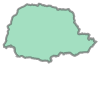

In [9]:
print('Estado: ' + map_info.nome[2])
map_info.geometry[2]

In [10]:
map_data = pd.read_sql_query("""
SELECT c.customer_state,
    COUNT(DISTINCT c.customer_unique_id) as total_customers
FROM customers c 
INNER JOIN geolocation g
ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY 1
""", conn)

map_data.head(5)

,customer_state,total_customers
0,AC,77
1,AL,400
2,AM,143
3,AP,67
4,BA,3268


In [11]:
map_info.rename({'sigla':'customer_state'}, axis = 1, inplace = True) 

Brazil = map_info.merge(map_data, on = 'customer_state', how = 'left')

Brazil[['customer_state', 'total_customers', 'geometry']].head()

,customer_state,total_customers,geometry
0,GO,1944,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,MS,694,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,PR,4871,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."
3,MG,11248,"MULTIPOLYGON (((-44.21152 -14.22955, -44.20750..."
4,SE,341,"MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ..."


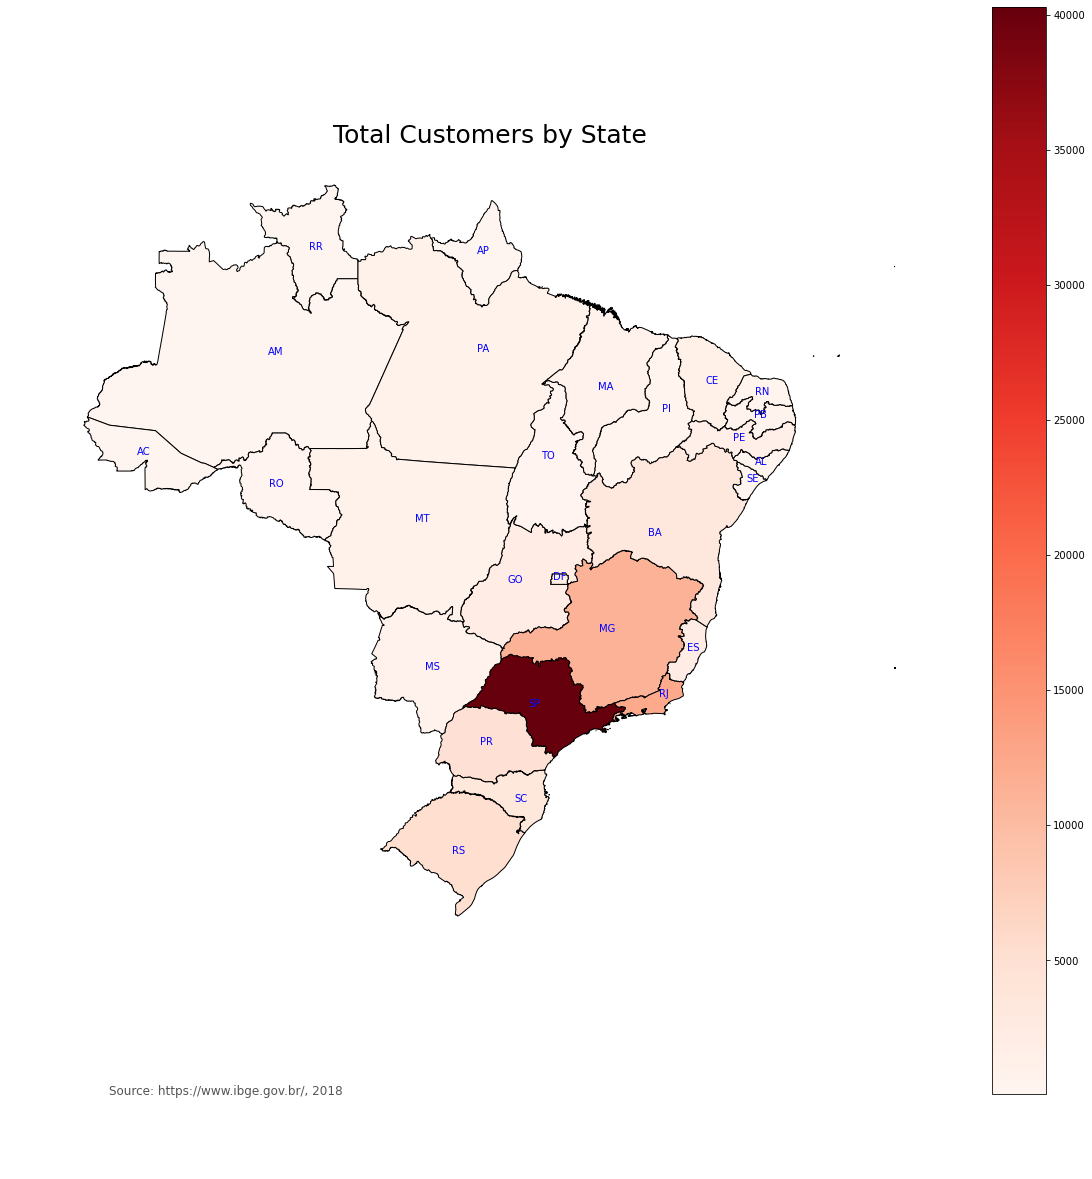

In [57]:
fig, ax = plt.subplots(1, figsize=(20, 20))

Brazil['coords'] = Brazil['geometry'].apply(lambda x: x.representative_point().coords[:])
Brazil['coords'] = [coords[0] for coords in Brazil['coords']]

Brazil.plot(column = 'total_customers',
            cmap = 'Reds',
            figsize = (16,10),
            legend = True,
            edgecolor = 'black',
            ax=ax)

for idx, row in Brazil.iterrows():
    plt.annotate(s=row['customer_state'], xy=row['coords'],
                 horizontalalignment='center', color='blue')

ax.axis('off')
ax.set_title('Total Customers by State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: https://www.ibge.gov.br/, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

            
plt.savefig('customers_by_state_map.png', dbi = 300, bbox_inches='tight')  

            


In [36]:
map_data2 = pd.read_sql_query("""
SELECT c.customer_state,
    CAST(SUM(op.payment_value) AS int) as total_value
FROM customers c 
INNER JOIN geolocation g
ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
INNER JOIN orders o 
ON c.customer_id = o.customer_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
GROUP BY 1
""", conn)

map_data2.head(5)

,customer_state,total_value
0,AC,1815873
1,AL,8474865
2,AM,1052239
3,AP,1187606
4,BA,74143589


In [39]:
map_info.rename({'sigla':'customer_state'}, axis = 1, inplace = True) 

Brazil2 = map_info.merge(map_data2, on = 'customer_state', how = 'left')

Brazil2[['customer_state', 'total_value', 'geometry']].head()

,customer_state,total_value,geometry
0,GO,24573188,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,MS,11726412,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,PR,101369239,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."
3,MG,468418138,"MULTIPOLYGON (((-44.21152 -14.22955, -44.20750..."
4,SE,4994065,"MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ..."


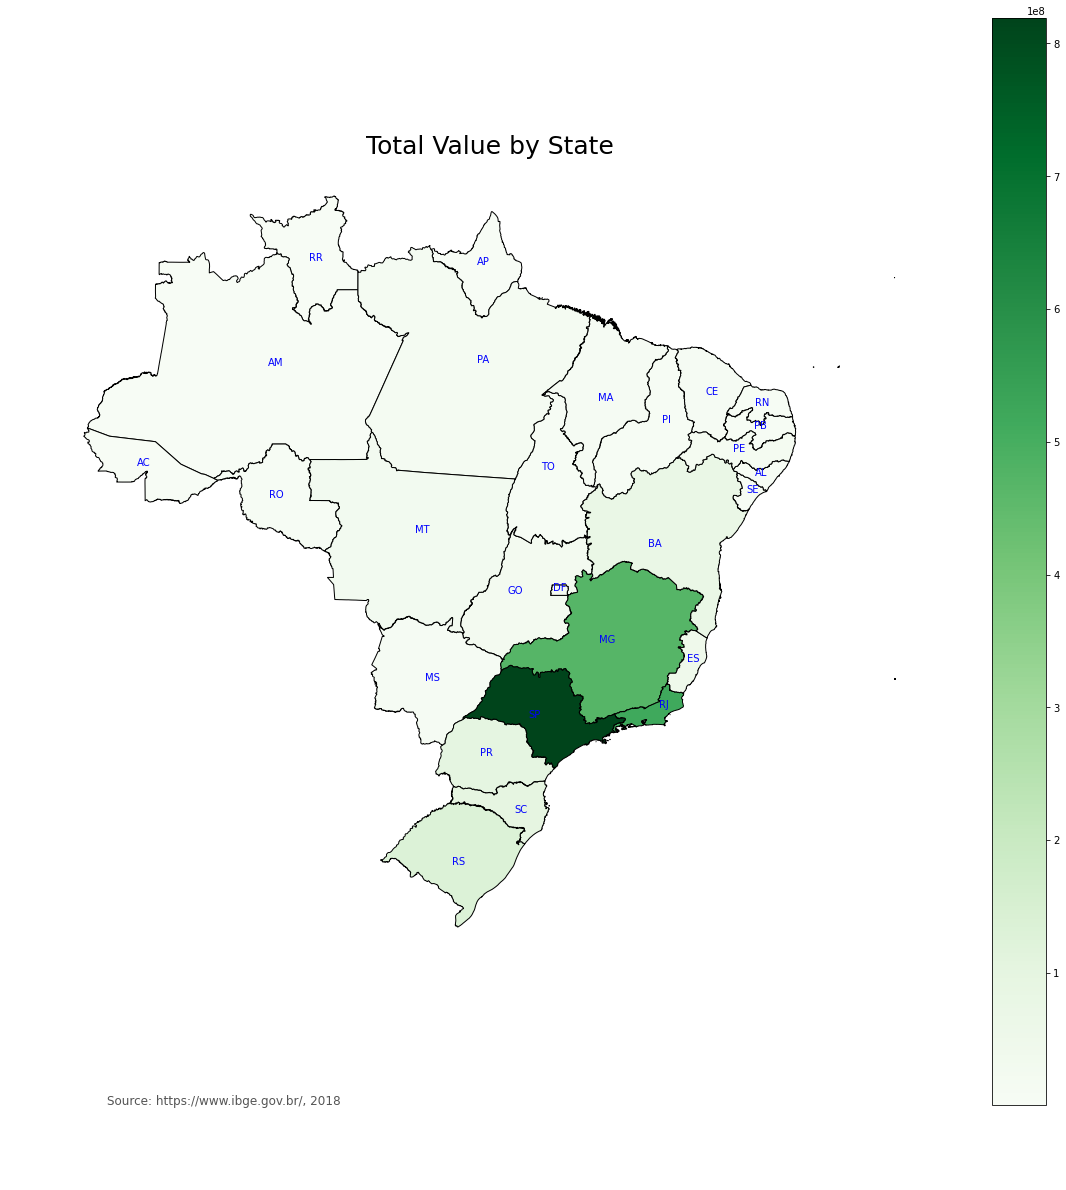

In [58]:
fig, ax = plt.subplots(1, figsize=(20, 20))

Brazil2['coords'] = Brazil2['geometry'].apply(lambda x: x.representative_point().coords[:])
Brazil2['coords'] = [coords[0] for coords in Brazil2['coords']]

Brazil2.plot(column = 'total_value',
            cmap = 'Greens',
            figsize = (16,10),
            legend = True,
            edgecolor = 'black',
            ax=ax)

for idx, row in Brazil2.iterrows():
    plt.annotate(s=row['customer_state'], xy=row['coords'],
                 horizontalalignment='center', color='blue')

ax.axis('off')
ax.set_title('Total Value by State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: https://www.ibge.gov.br/, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

            
plt.savefig('value_by_state_map.png', dbi = 300, bbox_inches='tight')  


In [47]:
map_data3 = pd.read_sql_query("""
SELECT c.customer_state,
    CAST(AVG(op.payment_value) AS int)||'R$' as avg_value_per_order
FROM customers c 
INNER JOIN geolocation g
ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
INNER JOIN orders o 
ON c.customer_id = o.customer_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
GROUP BY 1
""", conn)

map_data3.head(5)

,customer_state,avg_value_per_order
0,AC,225R$
1,AL,236R$
2,AM,182R$
3,AP,236R$
4,BA,190R$


In [48]:
map_info.rename({'sigla':'customer_state'}, axis = 1, inplace = True) 

Brazil3 = map_info.merge(map_data3, on = 'customer_state', how = 'left')

Brazil3[['customer_state', 'avg_value_per_order', 'geometry']].head()

,customer_state,avg_value_per_order,geometry
0,GO,178R$,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,MS,186R$,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,PR,155R$,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."
3,MG,155R$,"MULTIPOLYGON (((-44.21152 -14.22955, -44.20750..."
4,SE,196R$,"MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ..."


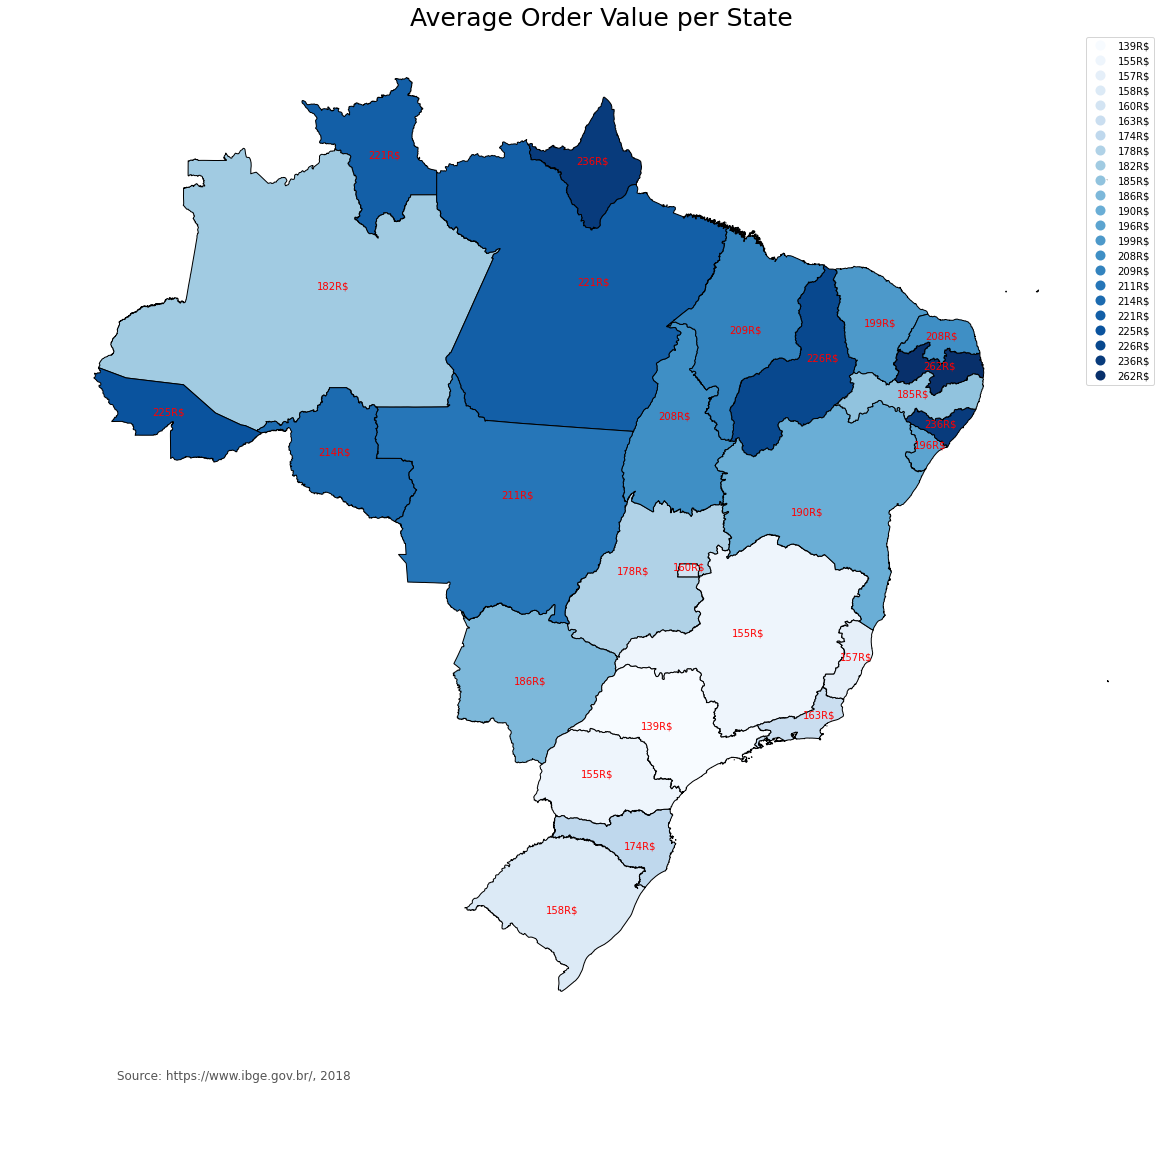

In [59]:
fig, ax = plt.subplots(1, figsize=(20, 20))

Brazil3['coords'] = Brazil3['geometry'].apply(lambda x: x.representative_point().coords[:])
Brazil3['coords'] = [coords[0] for coords in Brazil3['coords']]

Brazil3.plot(column = 'avg_value_per_order',
            cmap = 'Blues',
            figsize = (16,10),
            legend = True,
            edgecolor = 'black',
            ax=ax)

for idx, row in Brazil3.iterrows():
    plt.annotate(s=row['avg_value_per_order'], xy=row['coords'],
                 horizontalalignment='center', color='red')

ax.axis('off')
ax.set_title('Average Order Value per State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: https://www.ibge.gov.br/, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

            
plt.savefig('avg_value_per_order_by_state_map.png', dbi = 300, bbox_inches='tight')  
